In [1]:
import pandas as pd
import numpy as np
import os
np.random.seed(42)
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(os.path.abspath(".."))  

from FinalToolModels.models import *
from FinalToolModels.simulate import *
from FinalToolModels.plot import *
from FinalToolModels.train import *
from FinalToolModels.split_dataset import *

# === Paths ===
path_in = os.path.join("../Data")  # parent directory

###################### ======================== Case Study 1 ======================= ###########################

file_path = os.path.join(path_in, "dataset2.xlsx")
cs1 = pd.read_excel(file_path)

cs1["INDOOR_TEMP"] = cs1[["RTD31", "RTD34", "RTD37", "RTD40", "RTD41"]].mean(axis=1)
# Rename columns
rename_mapping = {
        'Tout': 'OUTDOOR_TEMP',
        'PhRad_actual_power': 'PHI_H',
        'SolGlob': 'PYRANOMETER'
    }
cs1 = cs1.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

cs1['Time'] = pd.to_datetime(cs1['Time'])
cs1 = cs1.set_index('Time')
cs1_surface_area = 100  # m² 
cs1 = cs1.iloc[0:960]

train_cs1, val_cs1, test_cs1 = split_dataset(cs1, testing_days=3, val_split=0.3)


## 1R1C


=== Best result ===
Best Trial Validation #: 74
Best Trial Training #: 36
Best RMSE Validation: 0.2818
RMSE Training of Best Validation : 0.0226
Best RMSE Training: 0.0226
Best initialization Validation: {'R_in_a': 0.09458109306026438, 'C_in': 184490185.72665733, 'Ain': 7.956805828084081}
Best initialization Training: {'R_in_a': 0.22956936732613084, 'C_in': 39412975.004567705, 'Ain': 8.693253835960126}
Best parameters Validation: {'R_in_a': 0.01347430490591823, 'C_in': 23043303.488289155, 'Ain': 3.472482194660791, 'fh': 1, 'Objective': 0.022632530669965234, 'Solve_time': 0.03249979019165039}
Best parameters Training: {'R_in_a': 0.013474304904056975, 'C_in': 23043303.48760187, 'Ain': 3.472482201821876, 'fh': 1, 'Objective': 0.02263253066996137, 'Solve_time': 0.03180813789367676}
Solve Time: 9.193745374679565


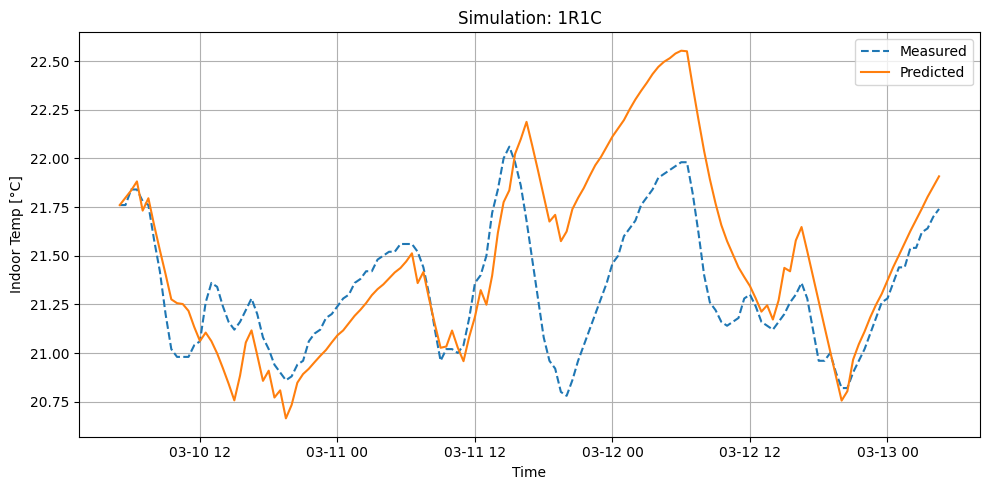

In [2]:
# Bounds 
bounds_cs1 = {
        "R_in_a": (0.001, 1),
        "C_in": (1e6, 5e8),
        "Ain": (0.001, 0.3 * cs1_surface_area)
    }
###################### ======================== Case Study 1 ======================= ###########################

model_1r1c_cs1, parameters_1r1c_cs1, best_initialization_1r1c_cs1, validation_pred_1r1c_cs1, initialize_testing_1r1c_cs1, all_trials_1r1c_cs1 = train_greybox_model_with_validation_process(
    train_df=train_cs1, val_df=val_cs1, model_type="1R1C", bounds=bounds_cs1, 
    num_trials=100, deltaT=1800, show_plot=False, log=False)
initialize_testing_1r1c_cs1['Tin'] = test_cs1['INDOOR_TEMP'].iloc[0]
# --- Run Simulation for Testing ---
validation, t_pred_1r1c_cs1, t_true_1r1c_cs1, test_pred = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters_1r1c_cs1, model_type="1R1C",
        initializations=initialize_testing_1r1c_cs1, show_plot=True
    )


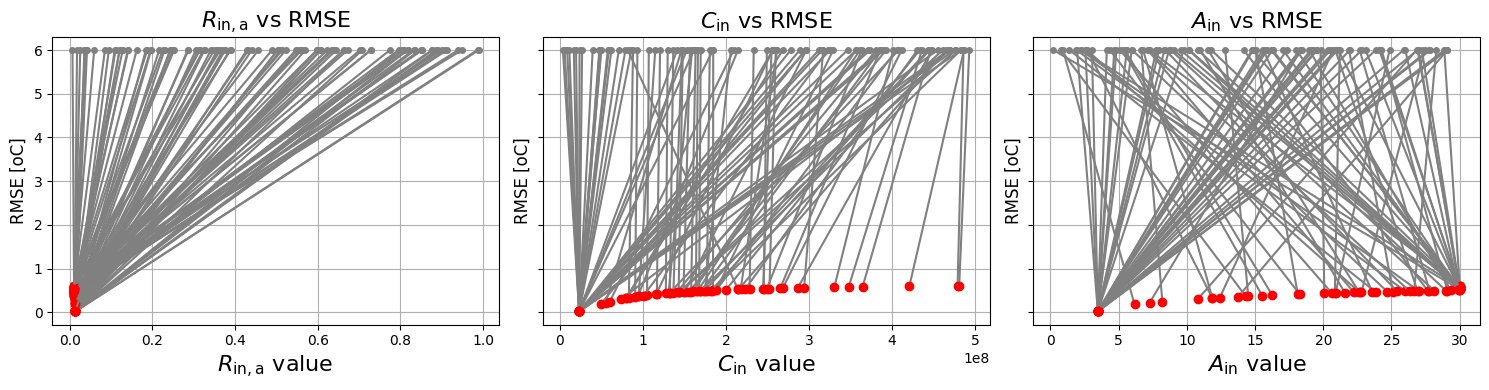

In [4]:
param_list = ['R_in_a', 'C_in', 'Ain']

plot_parameters_vs_rmse_multi(all_trials_1r1c_cs1, param_list, y_start=6, rmse_threshold=6)

# 2R2C


=== Best result ===
Best Trial Validation #: 63
Best Trial Training #: 85
Best RMSE Validation: 0.2249
RMSE Training of Best Validation : 0.0199
Best RMSE Training: 0.0198
Best initialization Validation: {'R_e_a': 0.6722208508551297, 'R_in_e': 0.02069082721660979, 'C_in': 52950182.41030235, 'C_e': 400158126.6012215, 'Ain': 5.357161316967955, 'Ae': 19.58273048944839, 'fh': 0.23818278104672652}
Best initialization Training: {'R_e_a': 0.6965924871022616, 'R_in_e': 0.34053508880429806, 'C_in': 362658618.992852, 'C_e': 33612814.05867224, 'Ain': 9.459394844580478, 'Ae': 16.18519927996774, 'fh': 0.7907231648389635}
Best parameters Validation: {'R_in_e': 0.1676904144154451, 'R_e_a': 0.0011540727690187538, 'C_in': 1830602.1534920477, 'C_e': 1211597.539172426, 'Ain': 0.11383912648758529, 'Ae': 15.216111598952901, 'fh': 0.07469375336297863, 'Objective': 0.019875283105694794, 'Solve_time': 0.3702061176300049}
Best parameters Training: {'R_in_e': 0.0012273698253586923, 'R_e_a': 0.01265609235038744

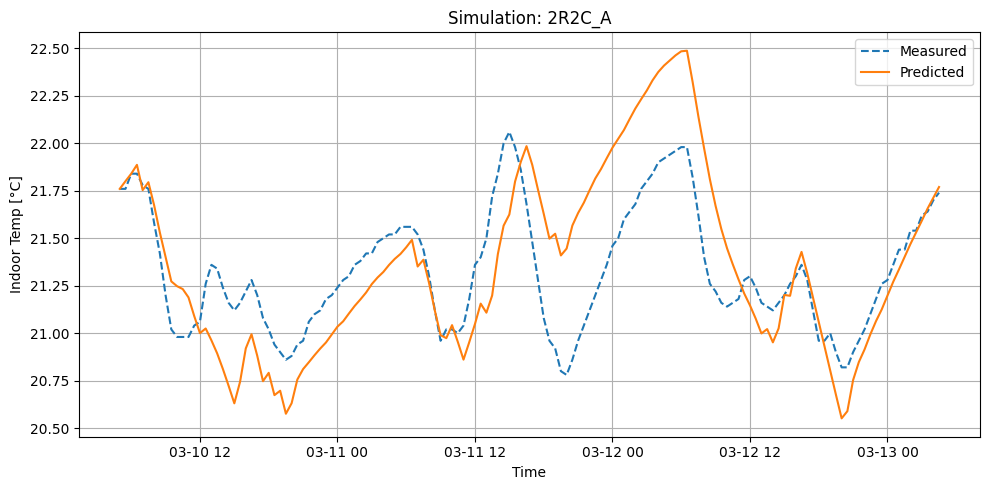

In [7]:
import numpy as np

# --- Bounds ---

bounds_cs1 = {
    "R_e_a": (0.001, 1),
    "R_in_e": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.001, 0.3 * cs1_surface_area),
    "Ae": (0.001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}
###################### ======================== Case Study 1 ======================= ###########################

model_2r2c_cs1, parameters, best_initialization,validation_pred_2r2c_cs1, initialize_testing_2r2c_cs1, all_trials_2r2c_cs1 = train_greybox_model_with_validation_process(
    train_df=train_cs1, val_df=val_cs1, model_type="2R2C_A", bounds=bounds_cs1, 
    num_trials=100, deltaT=1800, show_plot=False, log=False)

initialize_testing_2r2c_cs1['Tin'] = test_cs1['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
validation, t_pred_2r2c_cs1, t_true, test_pred = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters, model_type="2R2C_A",
        initializations=initialize_testing_2r2c_cs1, show_plot=True
    )

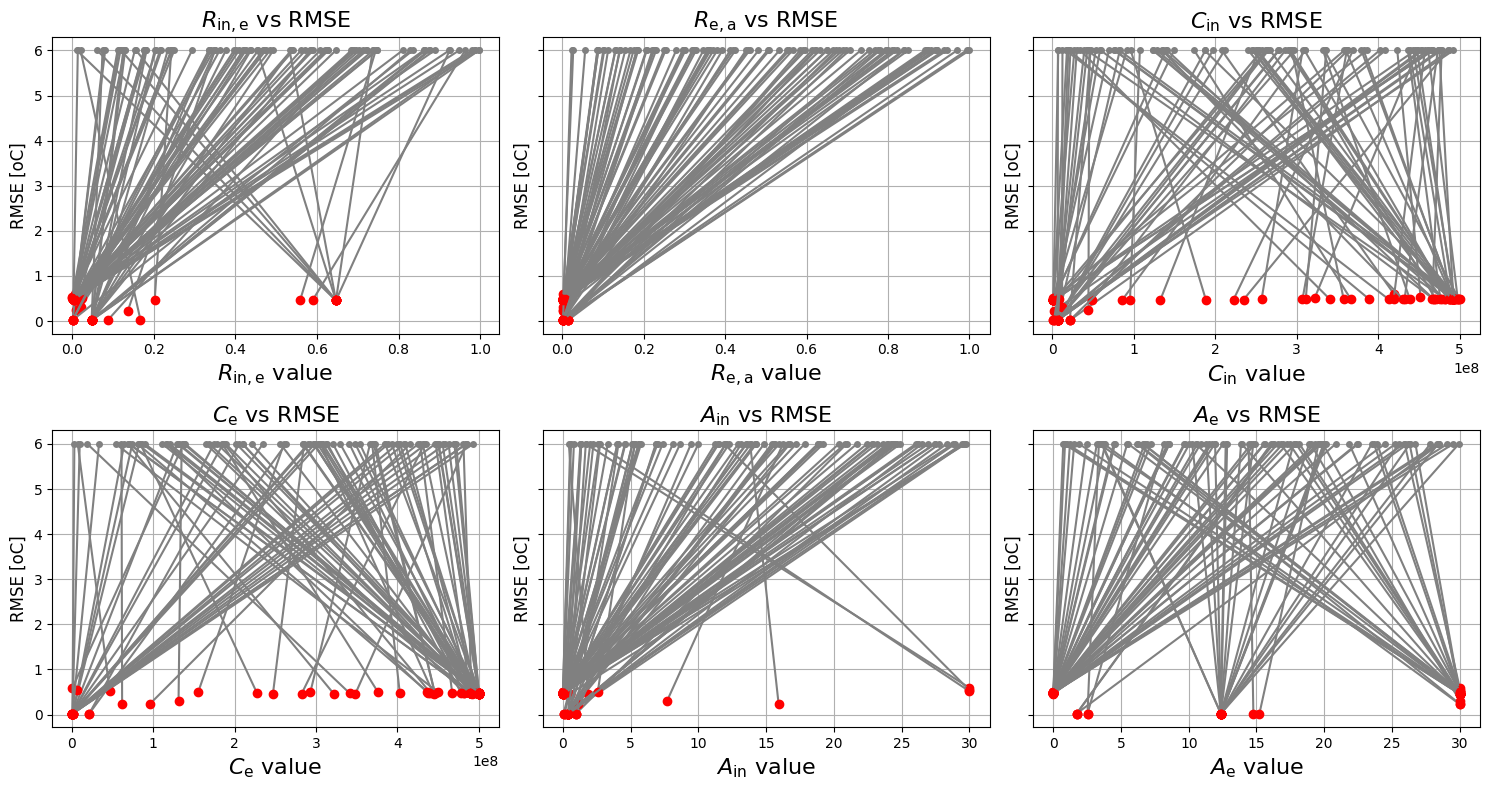

In [8]:
param_list = ['R_in_e','R_e_a', 'C_in', 'C_e', 'Ain', 'Ae']
plot_parameters_vs_rmse_multi(all_trials_2r2c_cs1, param_list, y_start=6, rmse_threshold=6)

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.17\x3a Maximum Number of Iterations
      Exceeded.

=== Best result ===
Best Trial Validation #: 36
Best Trial Training #: 39
Best RMSE Validation: 0.1833
RMSE Training of Best Validation : 0.0109
Best RMSE Training: 0.0109
Best initialization Validation: {'R_in_e': 0.6394808178776848, 'R_e_a': 0.8680503762255021, 'R_in_a': 0.4552851157782252, 'C_in': 258282418.26104587, 'C_e': 244934443.54820317, 'Ain': 20.005961039957377, 'Ae': 4.189623677563911, 'fh': 0.029973589872677953}
Best initialization Training: {'R_in_e': 0.8690360794942396, 'R_e_a': 0.5710391368921909, 'R_in_a': 0.03135667263714002, 'C_in': 465543399.0579819, 'C_e': 345073848.764749, 'Ain': 20.295433921978816, 'Ae': 6.4703330044162755, 'fh': 0.6588854702326572}
Best parameters Validation: {'R_in_e': 0.004297346431646782, 'R_e_a': 0.030298522267048877, 'R_in_a': 0.025823202990555412, 'C_in': 8640347.879526503, 'C_e': 15743

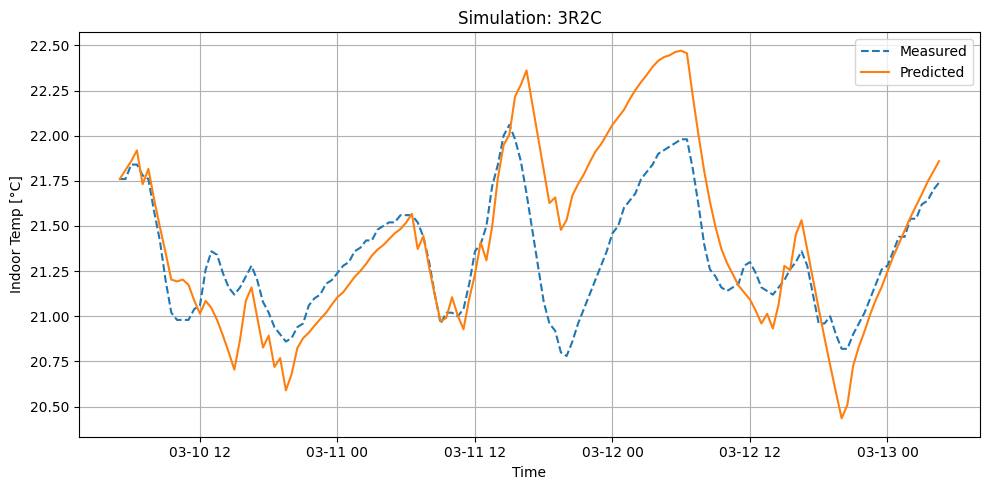

In [9]:
# --- Bounds ---

bounds_cs1 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}

###################### ======================== Case Study 1 ======================= ###########################

model_3r2c_cs1, parameters_3r2c_cs1, best_initialization_3r2c_cs1, validation_pred_3r2c_cs1, initialize_testing_3r2c_cs1, all_trials_3r2c_cs1 = train_greybox_model_with_validation_process(
    train_df=train_cs1, val_df=val_cs1, model_type="3R2C", bounds=bounds_cs1, 
    num_trials=100, deltaT=1800, show_plot=False, log=False)

initialize_testing_3r2c_cs1['Tin'] = test_cs1['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
validation, t_pred_3r2c_cs1, t_true, test_pred = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters_3r2c_cs1, model_type="3R2C",
        initializations=initialize_testing_3r2c_cs1, show_plot=True
    )

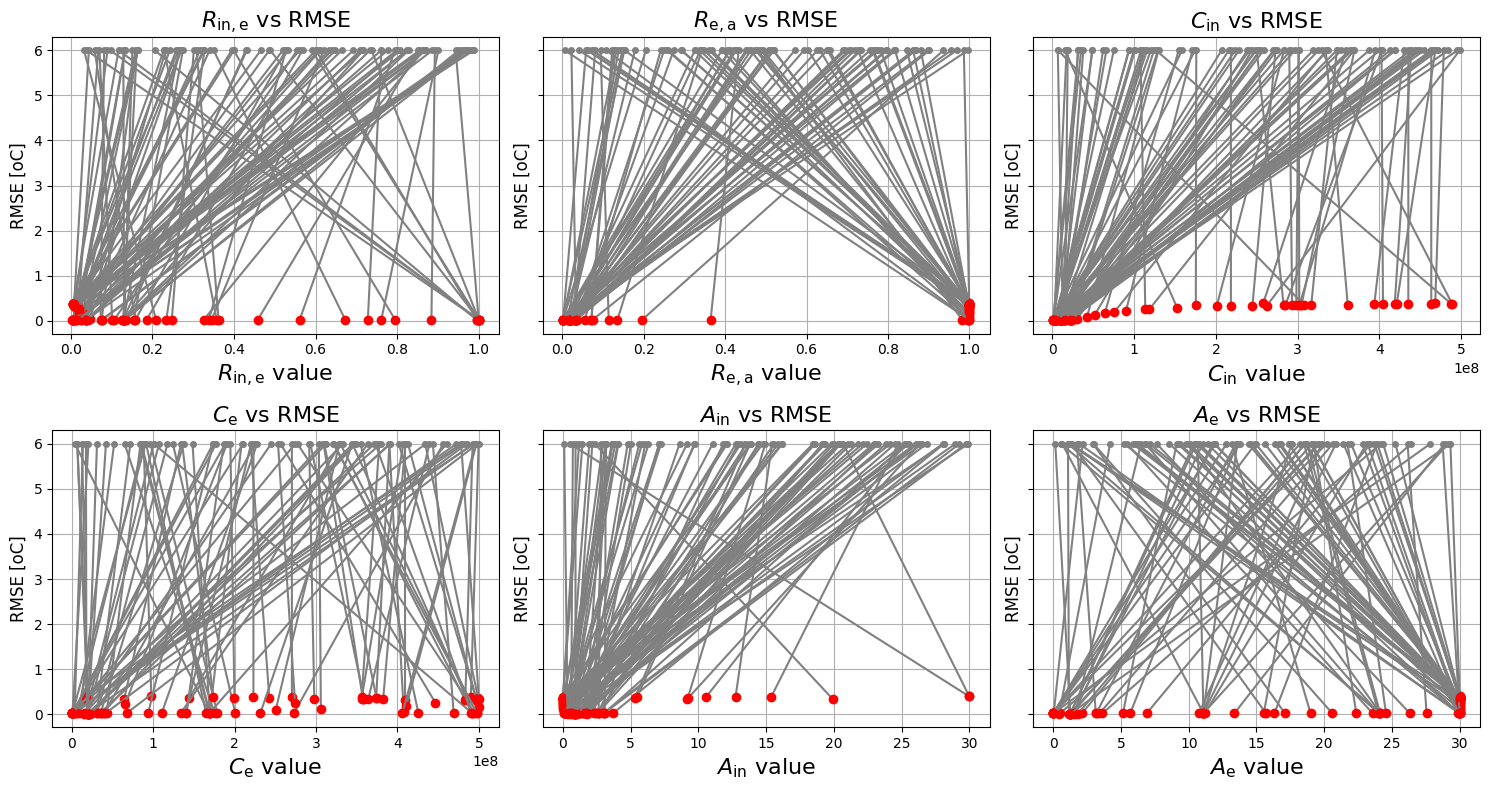

In [10]:
param_list = ['R_in_e','R_e_a', 'C_in', 'C_e', 'Ain', 'Ae']

plot_parameters_vs_rmse_multi(all_trials_3r2c_cs1, param_list, y_start=6, rmse_threshold=6)


=== Best result ===
Best Trial Validation #: 28
Best Trial Training #: 62
Best RMSE Validation: 0.1980
RMSE Training of Best Validation : 0.0108
Best RMSE Training: 0.0078
Best initialization Validation: {'R_int_in': 0.35606174925231227, 'R_in_e': 0.9418422601956872, 'R_e_a': 0.6692355014294682, 'R_in_a': 0.6793126167592197, 'C_int': 181725691.42992705, 'C_in': 297318002.65481895, 'C_e': 6253434.593038397, 'Aint': 19.082917782681626, 'Ain': 27.398617098592343, 'Ae': 18.37724279299774, 'fh_int': 0.873698593466345, 'fh_in': 0.7239730554660938, 'fh_e': 0.12055841640369025}
Best initialization Training: {'R_int_in': 0.2434931760564113, 'R_in_e': 0.9607057215621734, 'R_e_a': 0.19853185304452153, 'R_in_a': 0.9515269507411086, 'C_int': 497415863.83021635, 'C_in': 356207335.5061291, 'C_e': 490594493.4177608, 'Aint': 17.086236433035154, 'Ain': 7.786327541104392, 'Ae': 13.109932870380058, 'fh_int': 0.593560935378786, 'fh_in': 0.07308156202701499, 'fh_e': 0.6223432646172461}
Best parameters Vali

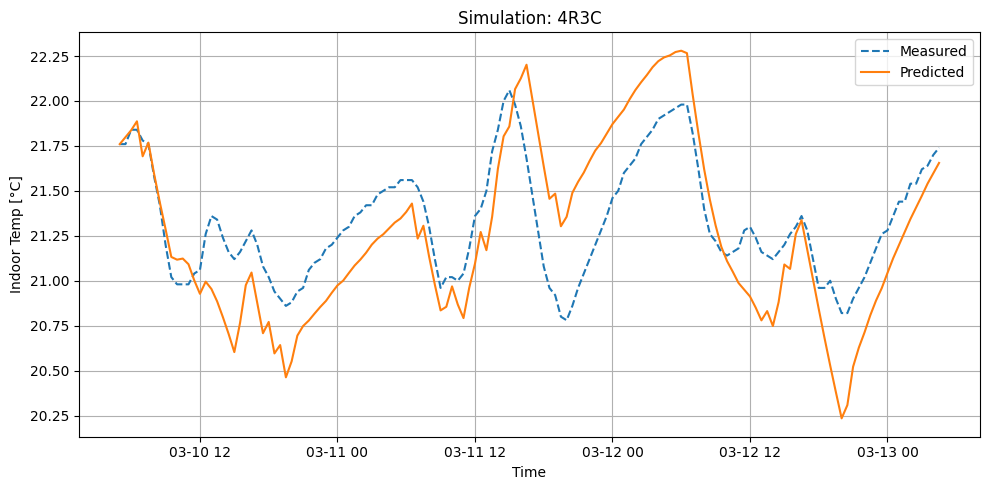

In [12]:
import numpy as np

# --- Bounds ---

bounds_cs1 = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs1_surface_area),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}

###################### ======================== Case Study 1 ======================= ###########################

model_4r3c_cs1, parameters_4r3c_cs1, best_initialization_4r3c_cs1, validation_pred_4r3c_cs1, initialize_testing_4r3c_cs1, all_trials_4r3c_cs1 = train_greybox_model_with_validation_process(
    train_df=train_cs1, val_df=val_cs1, model_type="4R3C", bounds=bounds_cs1, 
    num_trials=100, deltaT=1800, show_plot=False, log=False)

initialize_testing_4r3c_cs1['Tin'] = test_cs1['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
validation, t_pred_4r3c_cs1, t_true, test_pred = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters_4r3c_cs1, model_type="4R3C",
        initializations=initialize_testing_4r3c_cs1, show_plot=True
    )

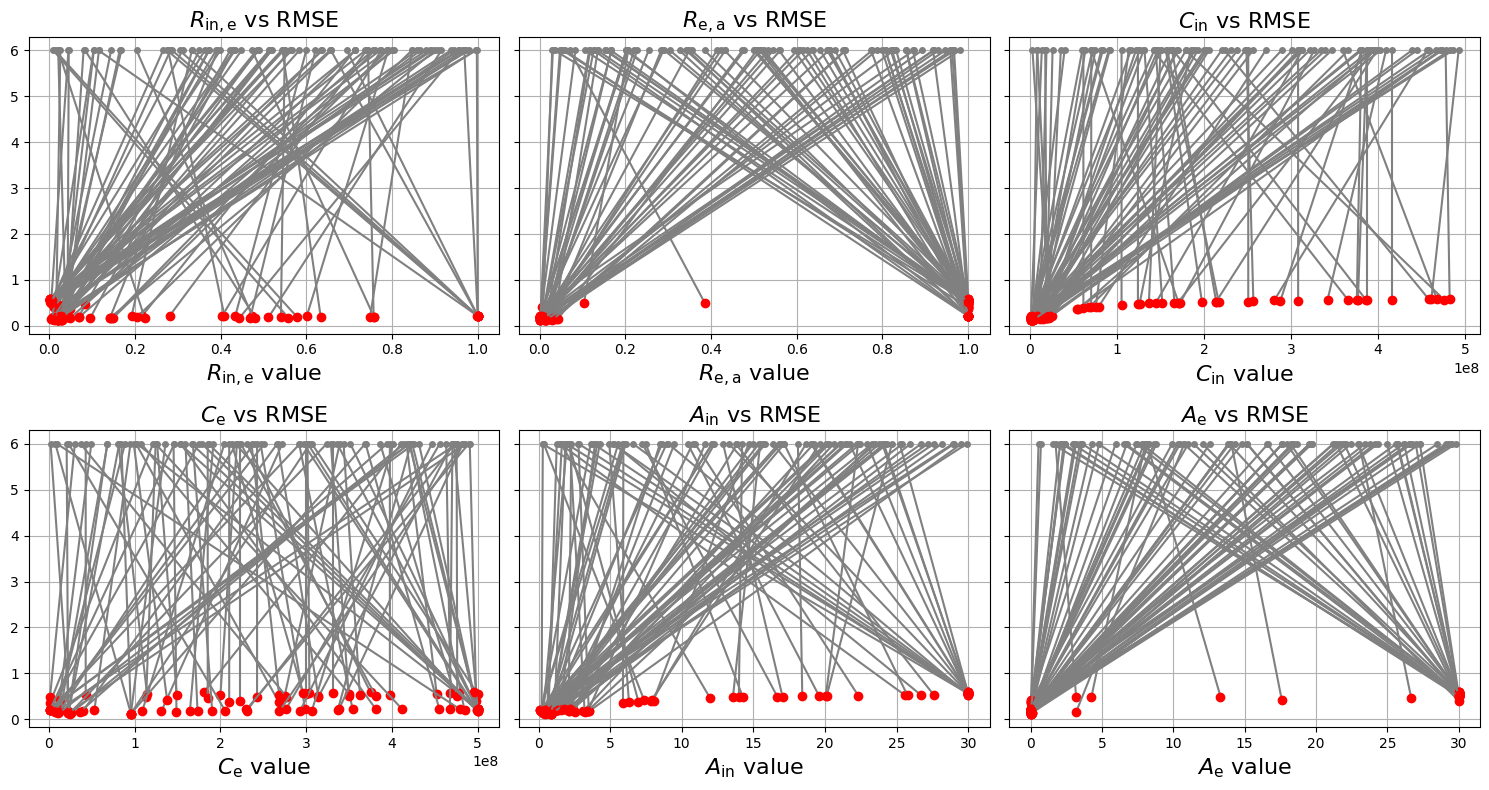

In [ ]:
param_list = ['R_in_e','R_e_a', 'C_in', 'C_e', 'Ain', 'Ae']

plot_parameters_vs_rmse_multi(all_trials_4r3c_cs1, param_list, y_start=6, rmse_threshold=6)